In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pyproj

##NEDAS/grid for handling regular/irregular grids
from grid import Grid, Converter


In [2]:
##read in ECMWF wind on lon/lat grid, call it grid1
from dataset import ECMWF
t = datetime(2022, 1, 3)
fname = ECMWF.filename('/scratch/data/', t)
x1, y1 = ECMWF.get_xy(fname)
wind = ECMWF.get_var(fname, 'wind', t) ##note: wind[0,:] = u and wind[1,:] = v
proj1 = ECMWF.proj

##define grid1, longitude (x) dimension is cyclic, latitude (y) contains a pole at 90 (index=0)
grid1 = Grid(proj1, x1, y1, cyclic_dim='x', pole_dim='y', pole_index=(0,))


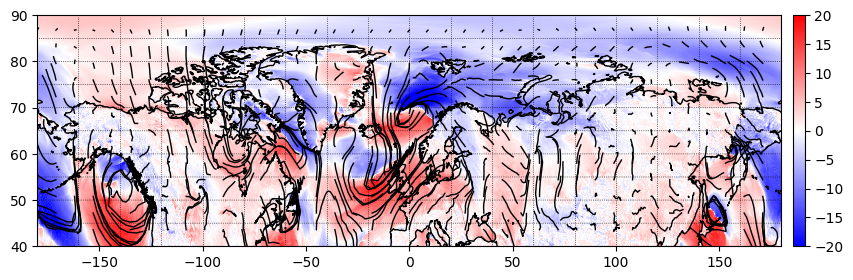

In [3]:
##you can visualize data using routines provided by the grid object
##start a figure
plt.figure(figsize=(10,3))
ax = plt.subplot(111)

##plot the u-wind on lon/lat grid
grid1.plot_field(ax, wind[0,:], vmin=-20, vmax=20, cmap='bwr')

##you can plot the vectors also, but don't forget to scale the velocity by cos(lat)
wind_sc = wind * np.cos(grid1.y*np.pi/180.)

##here, we apply uneven spacing in lon, lat directions
##don't show vector heads (they are distorted)
##and num_steps let's vectors to curve (they become trajectory-like)
grid1.plot_vectors(ax, wind_sc, spacing=(0.5, 0.2), showhead=False, num_steps=10)

##show the land for a complete map
grid1.plot_land(ax, color=None, linecolor='k')


In [4]:
##read in sea ice states from nextsim output, on irregular mesh, call it grid2
import models.nextsim as nx
fname = "/scratch/nextsim_ens_runs/init_run_5km/restart/field_20210102T000000Z.bin"
x2, y2 = nx.nodes_xy(fname.replace('field','mesh'))
tri2 = nx.triangulation(fname.replace('field','mesh'))
sid = nx.get_var(fname, 'seaice_drift')    ##sea ice drift, sid[0,:]=siu, sid[1,:]=siv
sit = nx.get_var(fname, 'seaice_thick') ##sea ice thickness

##define grid2, for regular=False, tri2.triangles provides indices for each elements' triangular vertices
grid2 = Grid(nx.proj, x2, y2, regular=False, triangles=tri2.triangles)


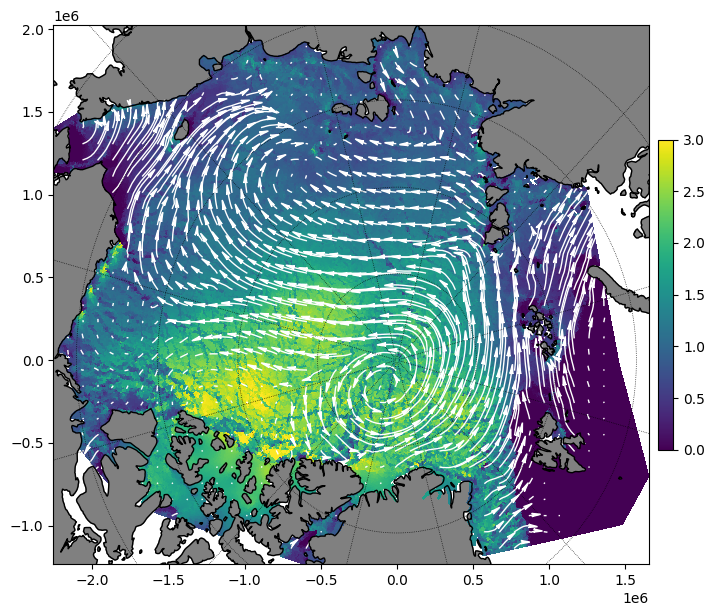

In [5]:
##again, visualize data in the native mesh
plt.figure(figsize=(8,7))
ax = plt.subplot(111)

##show thickness as shadings, the plot_field function calls plt.tripcolor for irregular mesh
grid2.plot_field(ax, sit, vmin=0, vmax=3, cmap='viridis')

##show ice drift vector field in white arrows
grid2.plot_vectors(ax, sid, linecolor='w')

##show the land with gray color, here we show all the options for plot_land()
grid2.plot_land(ax, color=[.5, .5, .5], linecolor='k', linewidth=1,
                showgrid=True, dlon=30, dlat=5)


In [6]:
##now we define a regular reference grid, where we gather different variables

##define projection using pyproj.Proj
##the proj object can convert (lon,lat) to the coordinates (x,y) in the specified projection
##  x, y = proj(lon, lat)
##  also, backwards: lon, lat = proj(x, y, inverse=True)
##so, if you have a model projection that is not included in pyproj, you can describe a function
##mapping between lon,lat and x,y and pass it in as proj() here

##pick an option:
##stereographic (a different rotation from nextsim mesh)
proj = pyproj.Proj("+proj=stere +a=6378273 +b=6356889.448910593 +lat_0=90 +lon_0=0 +lat_ts=60")
##make a regular grid with resolution dx, in meters
x, y = Grid.init_regular_grid(-3e6, 3e6, -3e6, 3e6, dx=2e4)


In [7]:
##or lambert conformal, just for fun:
proj = pyproj.Proj("+proj=lcc +lon_0=-180 +lat_1=40 +lat_2=60")
x, y = Grid.init_regular_grid(-3e6, 3e6, 5e6, 11e6, dx=2e4)

##or try your own projection:
#proj = ?

In [8]:
##define reference grid object
grid = Grid(proj, x, y)

##create converter objects to go from grid1/grid2 to the reference grid
##  the computation of rotation matrix (for vector field), and interpolation weights
##  are done in the init of object, then they are stored, so the actual convert can
##  be done very quickly
cnv1 = Converter(grid1, grid)
cnv2 = Converter(grid2, grid)


In [9]:
##convert the variables
## is_vector tells the converter that the vector field needs rotation
## method = "linear" (default) or "nearest" for interpolation
wind_ = cnv1.convert(wind, is_vector=True, method='linear')
sit_ = cnv2.convert(sit)
sid_ = cnv2.convert(sid, is_vector=True)


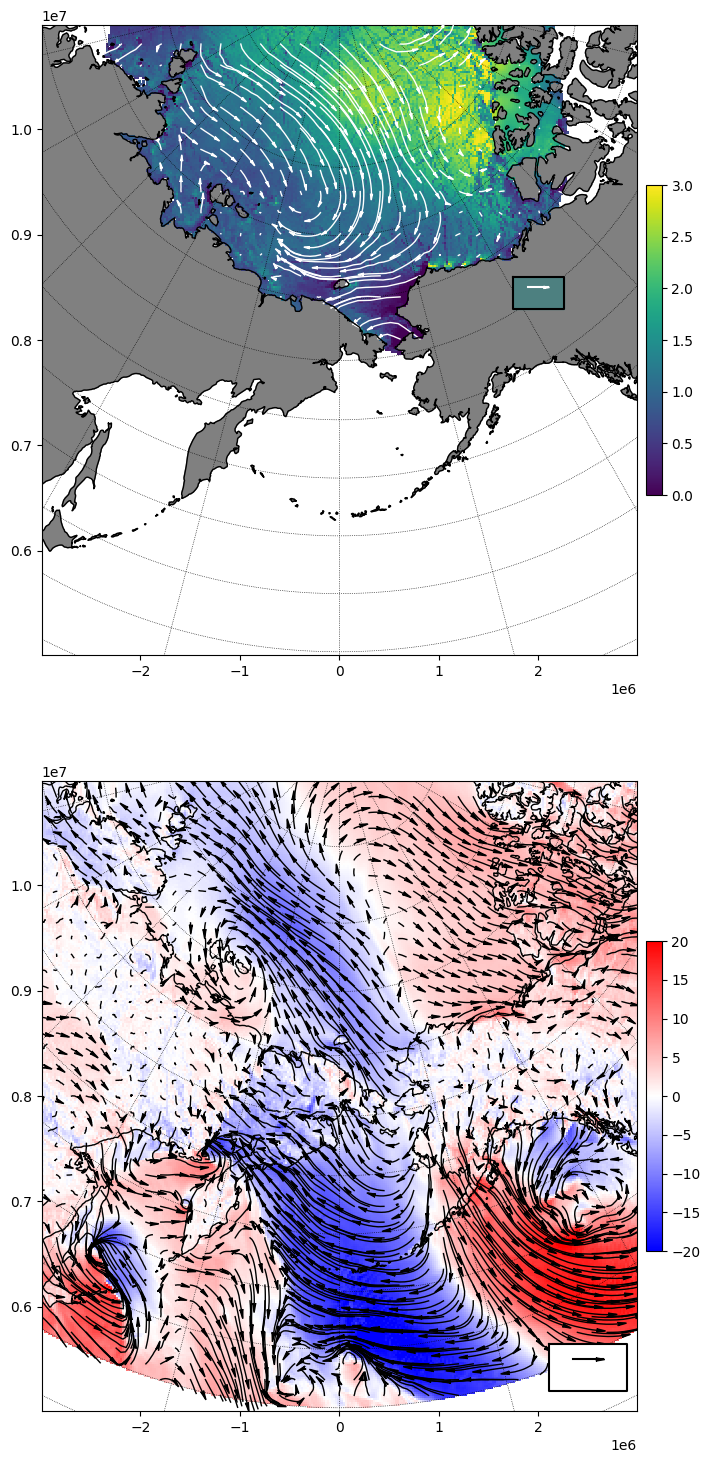

In [10]:
##now we plot some variables from both grid1,grid2 on the reference grid
plt.figure(figsize=(8,18))

##here we show all the parameters for plot_field() and plot_vectors(), the program
##tries to set parameters optimally, see grid.py for more details.

##sea ice properties on top:
ax = plt.subplot(211)
grid.plot_land(ax, color=[.5, .5, .5], linecolor='k')
grid.plot_field(ax, sit_, vmin=0, vmax=3, cmap='viridis')
grid.plot_vectors(ax, sid_, V=0.05, L=2e5, spacing=1, num_steps=10,
                  showref=True, ref_xy=(2e6, 8.5e6), refcolor=[.3, .5, .5],
                  linecolor='w', linewidth=1, showhead=True, headwidth=0.1, headlength=0.3)

##wind on bottom:
ax = plt.subplot(212)
grid.plot_land(ax, linecolor='k')
grid.plot_field(ax, wind_[0,:], vmin=-20, vmax=20, cmap='bwr')
grid.plot_vectors(ax, wind_, showref=True, ref_xy=(2.5e6, 5.5e6))
